We wish to find the eigenvalue of the following observable
2II−2XX+3YY−3ZZ. 

It as 4 eigen values -6, 4, 4, 6 respectively

And has 4 eigenstates as the 4 bell states

Let us first construct a custom VQE

In [1]:
from qiskit.quantum_info import SparsePauliOp

observable_1 = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

In [2]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

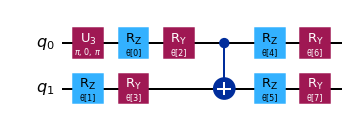

In [3]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

raw_ansatz.decompose().draw('mpl')

In [4]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler

estimator = Estimator()
sampler = Sampler()

In [5]:
import numpy as np

x0 = np.ones(raw_ansatz.num_parameters)
print(x0)

[1. 1. 1. 1. 1. 1. 1. 1.]


In [8]:
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})

end_time = time.time()
execution_time = end_time - start_time

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999988971083
       x: [ 1.779e+00  9.443e-01  1.571e+00  2.105e-05  1.938e+00
            1.204e+00  6.059e-01  6.059e-01]
    nfev: 136
   maxcv: 0.0

Let us check our result

In [9]:
from numpy.linalg import eigvalsh

solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))
print(f"Number of iterations = {result.nfev}")
print(f"Time = {execution_time}")
print(f"Percent error = {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}")

Number of iterations = 136
Time = 1.3940565586090088
Percent error = 1.84e-09


Thus we can see that the result is extremely close to the ideal

### Improve speed and accuracy
let us obtain our ideal eigenstate (+)

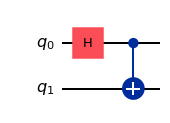

In [12]:
from qiskit import QuantumCircuit

ideal_qc = QuantumCircuit(2)
ideal_qc.h(0)
ideal_qc.cx(0,1)
ideal_qc.draw('mpl')

In [13]:
from qiskit.quantum_info import Statevector
Statevector(ideal_qc)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


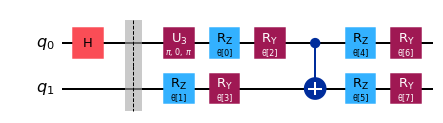

In [14]:
reference = QuantumCircuit(2)
reference.h(0)
reference.barrier()

ref_ansatz = raw_ansatz.decompose().compose(reference, front = True)
ref_ansatz.draw('mpl')

In [15]:
import time

start_time = time.time()

ref_result = minimize(cost_func_vqe, x0, args=(ref_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [16]:
experimental_min_eigenvalue_ref = cost_func_vqe(result.x, raw_ansatz, observable_1, estimator)
print(experimental_min_eigenvalue_ref)

-5.999999988971083


In [18]:
print(f"Number of iterations = {result.nfev}")
print(f"Time = {execution_time}")
print(f"Percent error = {abs((experimental_min_eigenvalue_ref - solution_eigenvalue)/solution_eigenvalue):.2e}")

Number of iterations = 136
Time = 2.079556941986084
Percent error = 1.84e-09


#### Changing initial point

In [19]:
import time

start_time = time.time()

x0 = [0, 0, 0, 0, 6, 0, 0, 0]

x0_1_result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [21]:
print("initial point 1")
print(f"Number of iterations = {x0_1_result.nfev}")
print(f"Time = {execution_time}")


initial point 1
Number of iterations = 118
Time = 1.434558629989624


In [28]:
start_time = time.time()

x0 = 6 * np.ones(raw_ansatz.num_parameters)

x0_2_result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [29]:
print("initial point 2")
print(f"Number of iterations = {x0_2_result.nfev}")
print(f"Time = {execution_time}")


initial point 2
Number of iterations = 109
Time = 1.0964295864105225


Now, let us experiment with different optimizers

In [30]:
start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="BFGS")

end_time = time.time()
execution_time = end_time - start_time

In [32]:
print("used bfgs instead of cobyla")
print(f"Number of iterations = {result.nfev}")
print(f"Time = {execution_time}")


used bfgs instead of cobyla
Number of iterations = 117
Time = 1.0439999103546143
